In [230]:
import sys
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install nltk



In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
url = 'https://raw.githubusercontent.com/breanna-s/Mental-Health-Chatbot/refs/heads/main/Combined%20Data.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [232]:
df.isnull().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [233]:
df.dropna(how='any', axis=0, inplace=True)
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [234]:
# Counts for each Mental Health status
df["status"].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [235]:
# get number of characters as this will be ussed to eliminate outliers later
df['num_chars'] = df['statement'].str.len()
print(df['num_chars'].describe())

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: num_chars, dtype: float64


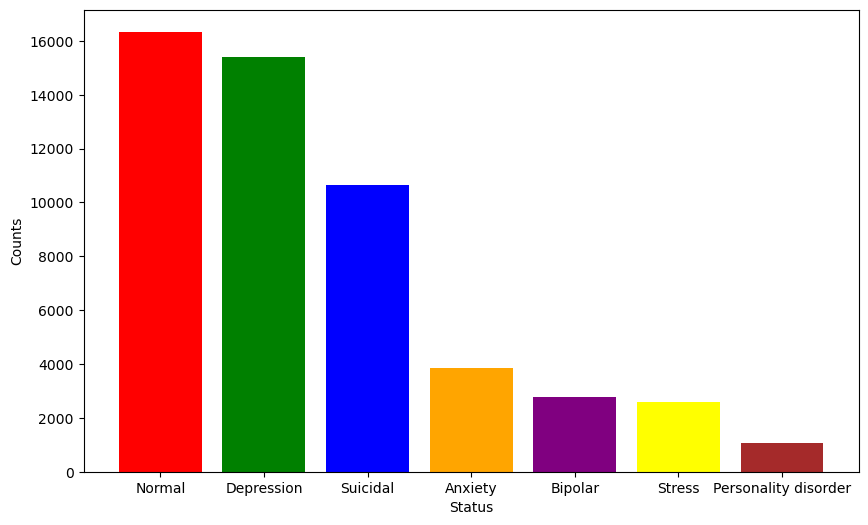

In [236]:
# Visualization of distribution of each Mental Health Status
s_count = df["status"].value_counts()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 

plt.figure(figsize=(10,6))
plt.bar(s_count.index, s_count.values, color=colors[:len(s_count)])
plt.xlabel("Status")
plt.ylabel("Counts")
plt.show()

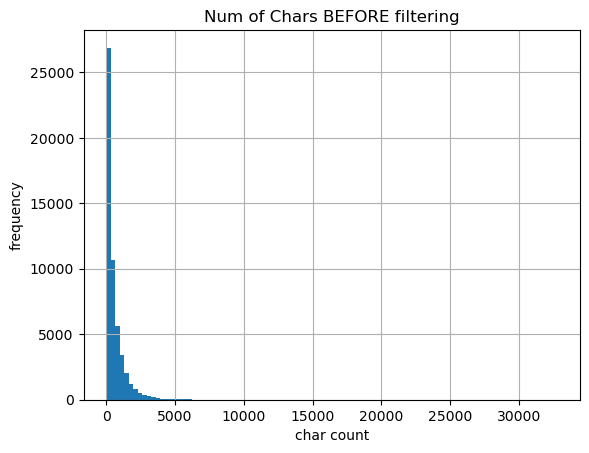

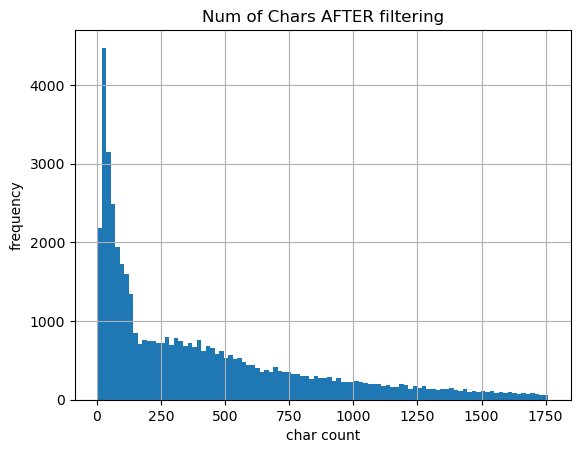

,Unnamed: 0,num_chars
count,52681.000000,52681.000000
mean,26365.706042,578.713863
std,15235.065306,846.269078
min,0.000000,2.000000
25%,13180.000000,80.000000
50%,26350.000000,317.000000
75%,39522.000000,752.000000
max,53042.000000,32759.000000


In [237]:
#remove outliers of the lower quarter percentile and upper quarter percentile of the number of characters

df['num_chars'].hist(bins=100)
plt.title('Num of Chars BEFORE filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()



lower_q = df['num_chars'].quantile(.25)
upper_q = df['num_chars'].quantile(.75)
q_range = upper_q - lower_q

lower_bound = lower_q - 1.5 * q_range
upper_bound = upper_q + 1.5 * q_range

filtered_df = df[(df['num_chars'] >= lower_bound) & (df['num_chars'] <= upper_bound) ]
filtered_df['num_chars'].hist(bins=100)
plt.title('Num of Chars AFTER filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()
df.describe()


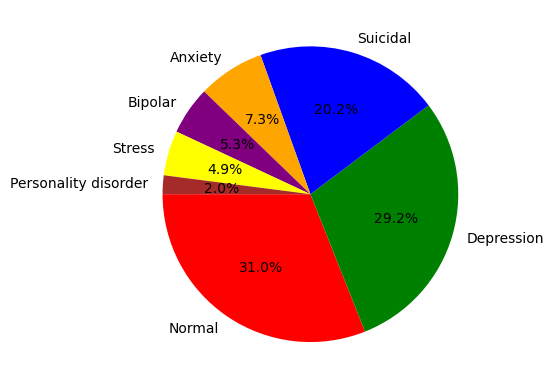

In [238]:
#data is skewed so will need to fix that at some point, shown as pie chart
colors =  ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 
plt.pie(s_count, labels=s_count.index, autopct='%.1f%%', colors=colors, startangle=180)
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1)) #this prevents a random print for some reason

   
#status: ('Suicidal', 36299) isnt suicidal, sh
#statement: @realDonaldTrump It already is! At least in France one doesn't die/loss everything when get sick &amp; have at least 1â¦ https://t.co/QYN3ku1Q8T

In [239]:
df['sentence_count'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_chars', 'sentence_count']].describe()

,num_chars,sentence_count
count,52681.000000,52681.000000
mean,578.713863,6.280215
std,846.269078,10.688388
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


In [240]:
#get random values for each of the status types as examples
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1))
for status, statement in random_statements.items():
    print(f"status: {status}")
    print(f"statement: {statement}", end="\n\n-----------------------------------------------\n")

status: ('Anxiety', 34814)
statement: Hanta Virus Hello,

About two weeks ago in central Alberta we were cleaning out a rental. I was sick already so just simply crashed on the mattress in the basement with the lights on.

Last week I seem to have gotten over the initial flue but have started to have headaches, vomiting etc. Sore muscles in my legs and lower back and one hell of a cough. Nothing coming up with the cough and no runny nose or anything. I feel very tired all the time, and it seems to be getting worse.

Its likely that its just a flu coming back, but am starting to get someone nervous it could be hantaviruous.

-----------------------------------------------
status: ('Bipolar', 49692)
statement: Trust issues I’ve been researching trust issues and coping mechanisms and an article I read brought up bipolar disorder and how trust issues can be indicative of bipolar. I have a lovely partner but I can’t scrape it from me to trust him, no fault of his own. He has done nothing to

In [241]:
import re
#convert the statements all to lower case to keep tokenization consistent
df['statement'] = df['statement'].str.lower()
#remove puncuation, markdown, urls, special chars
def remove_special_inputs(text):
    text = re.sub(r"http[s]?://\S+","",text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', "", text)
    # Remove handles (that start with '@')
    text = re.sub(r"@\w+","",text)
    # Remove punctuation and other special characters
    text = re.sub(r"[^\w\s]","",text)
    return text
df['statement'] = df['statement'].apply(remove_special_inputs)
df.head()


,Unnamed: 0,statement,status,num_chars,sentence_count
0,0,oh my gosh,Anxiety,10,1
1,1,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2,2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2
3,3,ive shifted my focus to something else but im ...,Anxiety,61,1
4,4,im restless and restless its been a month now ...,Anxiety,72,2


In [242]:
#need to tokenize each the elements in the statement column of the data
#use the word_tokenize from nltk to divide the string into individual words
df['tokens'] = df['statement'].apply(word_tokenize)
df.sample(5)



,Unnamed: 0,statement,status,num_chars,sentence_count,tokens
25879,25879,i have been in down for a few weeks now its le...,Depression,1189,6,"[i, have, been, in, down, for, a, few, weeks, ..."
24447,24447,guilt is externalit grabs at your heartstrings...,Depression,573,1,"[guilt, is, externalit, grabs, at, your, heart..."
7056,7056,why am i so stupid i fell for someone who cann...,Suicidal,475,8,"[why, am, i, so, stupid, i, fell, for, someone..."
452,452,no regrets or grudgesangry at things that have...,Anxiety,123,1,"[no, regrets, or, grudgesangry, at, things, th..."
13651,13651,i have decided to drop out of school i am beyo...,Suicidal,101,2,"[i, have, decided, to, drop, out, of, school, ..."


In [243]:
#need to stem the the tokens to eliminate prefix and suffixes to get the root word
#this will standardize the words used in the training data for the model, this takes about a minute to run fyi
stemmer = PorterStemmer() #initialize stemmer

def token_stemming(tokens):
  return ' '.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stem'] = df['tokens'].apply(token_stemming)

df.sample(5)

,Unnamed: 0,statement,status,num_chars,sentence_count,tokens,tokens_stem
46791,46791,possible misdiagnosis pmdd instead of bipolar ...,Bipolar,1571,17,"[possible, misdiagnosis, pmdd, instead, of, bi...",possibl misdiagnosi pmdd instead of bipolar i ...
18806,18806,i fucking hate my mental illness and have been...,Suicidal,261,1,"[i, fucking, hate, my, mental, illness, and, h...",i fuck hate my mental ill and have been work s...
51447,51447,does anybody else get overly hurt and offended...,Personality disorder,935,8,"[does, anybody, else, get, overly, hurt, and, ...",doe anybodi els get overli hurt and offend whe...
43717,43717,at work and a little sick,Normal,25,1,"[at, work, and, a, little, sick]",at work and a littl sick
3028,3028,im 25 but i dont have anything even though ive...,Normal,192,3,"[im, 25, but, i, dont, have, anything, even, t...",im 25 but i dont have anyth even though ive be...


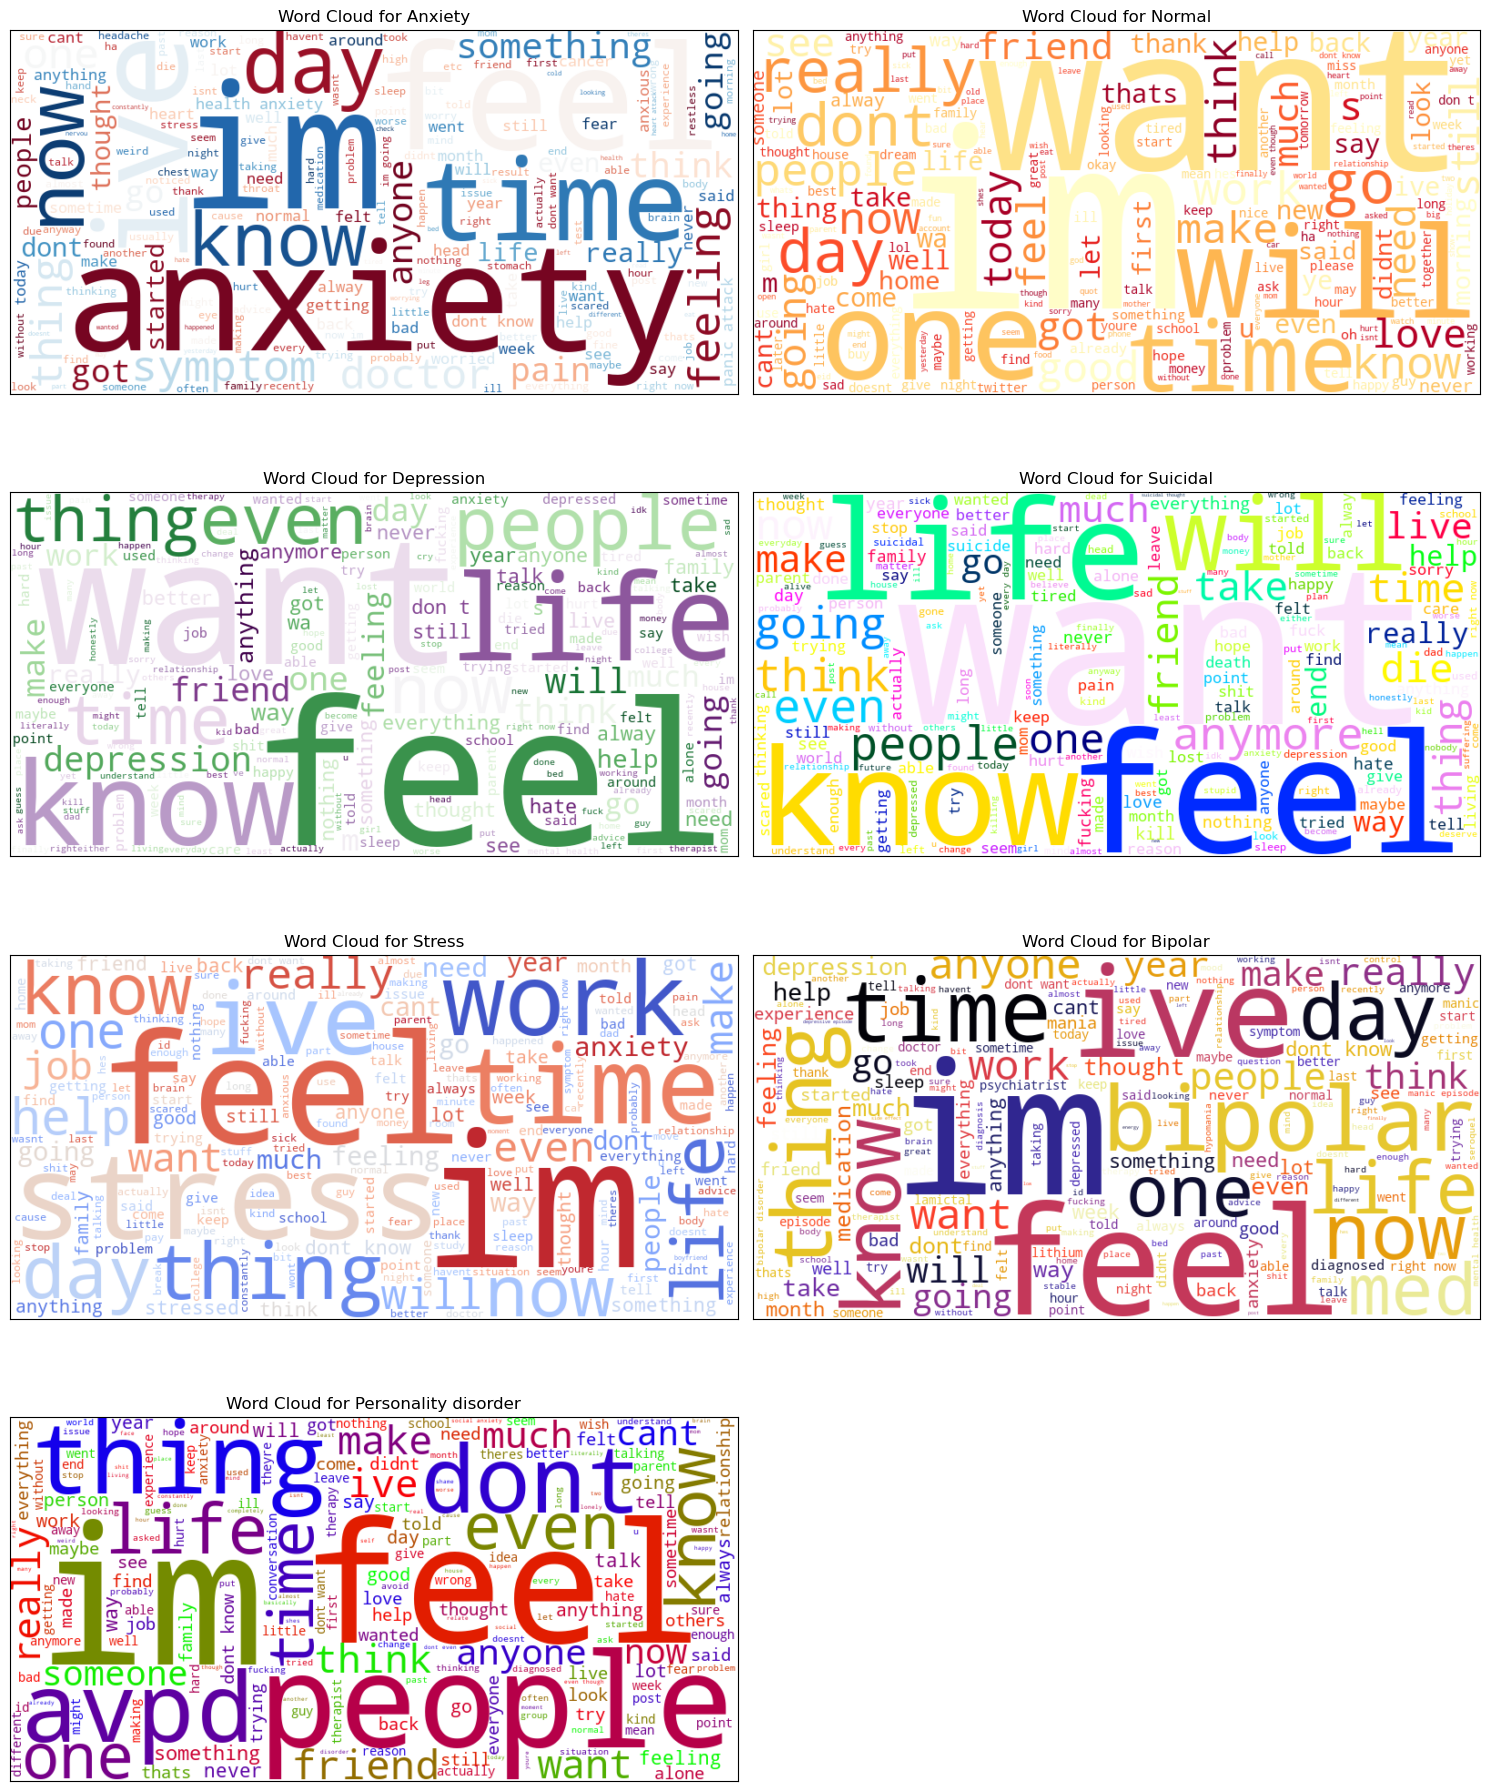

In [244]:
#word collages can help show the common words for each condition
#colormap =  RdBu

unique_status = df['status'].unique()
plt.figure(figsize=(15, 45))
color_map_array = ['RdBu', 'YlOrRd', 'PRGn_r','gist_ncar_r', 'coolwarm', 'CMRmap', 'brg']
for i, status in enumerate(unique_status):
  tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())
  word_cloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map_array[i]).generate(tokens_data)
  axes = plt.subplot(len(unique_status) // 2 + 1, 2, i+1)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title(f'Word Cloud for {status}')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-.85)
plt.show()


In [245]:
#set the x values we will be examining, the stemmed tokens, word and, char count
#we compare these against the status as the y values
x = df[['tokens_stem', 'num_chars', 'sentence_count']]
y = df['status']
print(y)


0        Anxiety
1        Anxiety
2        Anxiety
3        Anxiety
4        Anxiety
          ...   
53038    Anxiety
53039    Anxiety
53040    Anxiety
53041    Anxiety
53042    Anxiety
Name: status, Length: 52681, dtype: object


In [246]:
#encode the y values, status, to be represented as numerical values. turn anxiety to 0
#IF YOU GET AN ERROR RUNNING THIS, RUN THE CELL ABOVE AND TRY AGAIN, IF THIS FAILS IT OVERWRITES Y AND 
#PULLS A JUPYTER NOTEBOOK MOMENT WHERE Y SHOULDNT BE MODIFIED BUT AGAIN JUPYTER NOTEBOOKS 🤬
encoder = LabelEncoder()
y = encoder.fit_transform(y.values)
#print(y)


In [247]:
#we use train_test_split function on data
#idk when you are supposed to use a new cell in jupyter notebook typically
#im just doing it after doing an operation or function on some data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [248]:
#now we will convert the text to features 
#we do this via tfidf or Term Frequency-Inverse Document Frequency
#we determine how important a given word is to a status by determining the frequency of a word in the TOTAL dataset
#if word t in data set d the term frequency is equal to (num of t) / (num of words in d)
vector = TfidfVectorizer(ngram_range=(1, 2), max_features=50000) #ngram_range says it looks for 1 word phrases as well as 2 word phrases, need to limit size as it would be way to big
x_train_tfid = vector.fit_transform(x_train['tokens_stem'])
x_test_tfid = vector.fit_transform(x_test['tokens_stem'])

#now need the numerical features of the training and testing data
x_train_num = x_train[['num_chars', 'sentence_count']].values
x_test_num = x_test[['num_chars', 'sentence_count']].values

#lastly combine the tfid with the numerical values
combined_x_train = hstack([x_train_tfid, x_train_num])
combined_x_test = hstack([x_test_tfid, x_test_num])

print('feature word count: ', len(vector.get_feature_names_out())) #should be 50000
combined_x_train.shape #should be 42144, 50002

feature word count:  50000


(42144, 50002)

In [249]:
#now need random sampling
r = RandomOverSampler(random_state=42)
x_train_r, y_train_r = r.fit_resample(combined_x_train, y_train)
x_train_r.shape

(91245, 50002)

In [252]:
#this is a gradient booster algorithm.
#idk what it actually does bc ML seems to just be importing modules to
#the machine learning part
xgb_clf = XGBClassifier(learing_rate=.5, max_depth =7, n_estimators=500, random_state=42, tree_method ="hist")
xgb_clf.fit(x_train_r, y_train_r)
y_pred = xgb_clf.predict(combined_x_test)

c:\Users\conno\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\conno\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\conno\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is 

XGBoostError: [20:22:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [20:22:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device
